In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.transform import resize
import CA_model
import iceing
import evaluation
import initial_distributions
from tqdm import tqdm
import os

In [8]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['cyan', 'white', 'blue'])
bounds=[-100,0.5,3,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

## CA model

In [2]:
# py-spy record -o profile.svg -- python myprogram.py

In [3]:
# size = 1000

# Ht_0 = np.random.normal(loc = 0.15, scale = 0.1, size = (int(size/3), int(size/3)))
# Ht_0 = resize(Ht_0, (size, size))
# Ht_0 = np.heaviside(Ht_0, 0) * Ht_0 + 0.1

# # Ht_0 = np.random.normal(loc = 0.15, scale = 0.1, size = (size, size))
# h = np.zeros(shape = (size, size))


In [4]:
# initialize model with 'snow dune topography' Popovic et al., 2020

res = 200                       # size of the domain
mode = 'snow_dune'              # topography type
tmax = 2; dt = 0.1              # diffusion time and time-step if mode = 'diffusion' or mode = 'rayleigh'
g = 1                           # anisotropy parameter
sigma_h = 0.03                  # surface standard deviation
snow_dune_radius = 1.           # mean snow dune radius if mode = 'snow_dune'  
Gaussians_per_pixel = 0.2       # density of snow dunes if mode = 'snow_dune'  
snow_dune_height_exponent = 1.  # exponent that relates snow dune radius and snow dune height if mode = 'snow_dune'

mean_freeboard = 0.1

Tdrain = 10.; dt_drain = 0.5    # time and time-step of to drainage

# create topography
Ht_0 = initial_distributions.Create_Initial_Topography(res = res, mode = mode, tmax = tmax, dt = dt, g = g, sigma_h = sigma_h, h = mean_freeboard, snow_dune_radius = snow_dune_radius,
            Gaussians_per_pixel = Gaussians_per_pixel, number_of_r_bins = 150, window_size = 5, snow_dune_height_exponent = snow_dune_height_exponent)


size = res
h = np.zeros(shape = (size, size))

/Users/paulhosek/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulhosek/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
ca_model = CA_model.CA_model(Ht_0, h, dt = 15, dx = 1, periodic_bounds=True)
# ca_model.H[ca_model.psi == ca_model.psi.min()] = 0
hs = []
Hs = []
Hts = []
# hes = []

In [6]:
experiment_name = "Test_thickness"
# os.mkdir(f"experiments/{experiment_name}")
# os.mkdir(f"experiments/{experiment_name}/pond")
# os.mkdir(f"experiments/{experiment_name}/ice")
# os.mkdir(f"experiments/{experiment_name}/freeboard")
#iterations = 1440 # 6h @ 15s/iteration
iterations = 500

for i in tqdm(range(400), leave=False):
    h, H, Ht = ca_model.run(iterations)

    np.save(f"experiments/{experiment_name}/pond/_i={i}",ca_model.h)
    np.save(f"experiments/{experiment_name}/ice/_i={i}",ca_model.H)
    np.save(f"experiments/{experiment_name}/freeboard/_i={i}",ca_model.Ht)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
evaluation.make_plots("Test4plotting_full_thickness", threshold = 0.01)

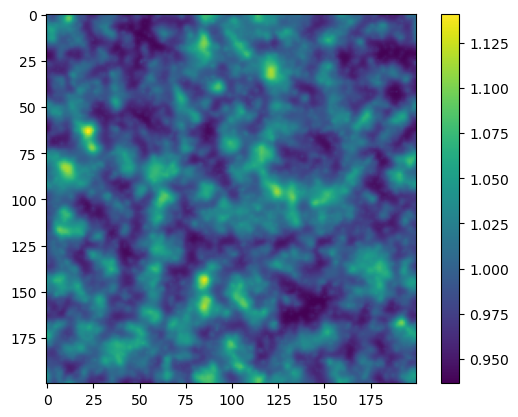

In [ ]:
plt.imshow(np.ma.masked_where(H<=0, H))
plt.imshow(H)
plt.colorbar()

## Evaluation CA

In [10]:
areas_ca, perimeters_ca = evaluation.perim_area(np.where(h>0.01, -1, 1), pond_val = -1, ice_val = 1)

In [11]:
plt.figure()
plt.scatter(areas_ca, perimeters_ca)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

ValueError: Data has no positive values, and therefore can not be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7f7e0adf0e50> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 640x480 with 1 Axes>

## Ising model

In [30]:
iceing_test = iceing.iceing_model(0.45, 1000)

In [31]:
ponds, sums = iceing_test.run(15_000_000)

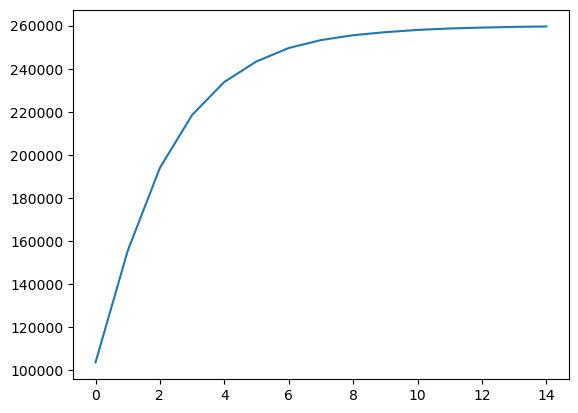

In [32]:
plt.plot(sums)

In [33]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'white'])
bounds=[-100,0,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

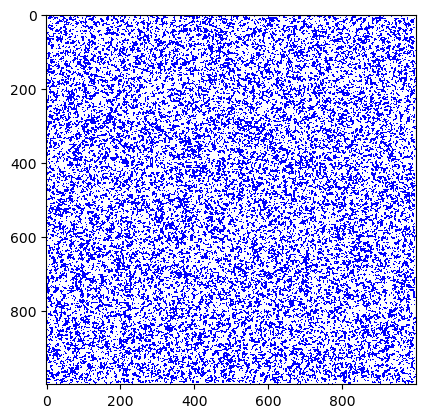

In [34]:
# plot ponds
plt.imshow(ponds, cmap=cmap, norm=norm)

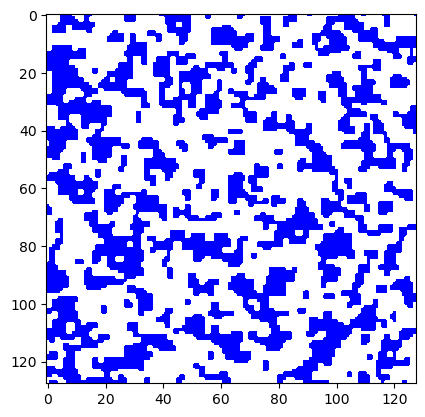

In [35]:
# zoom in
plt.imshow(ponds[100:228,100:228], cmap=cmap, norm=norm)

## Evaluation Ising
Fractal dimension plot is still missing.

In [36]:
areas_ising, perimeters_ising = evaluation.perim_area(ponds, pond_val = -1, ice_val = 1)

Text(0, 0.5, 'perimeter [m]')

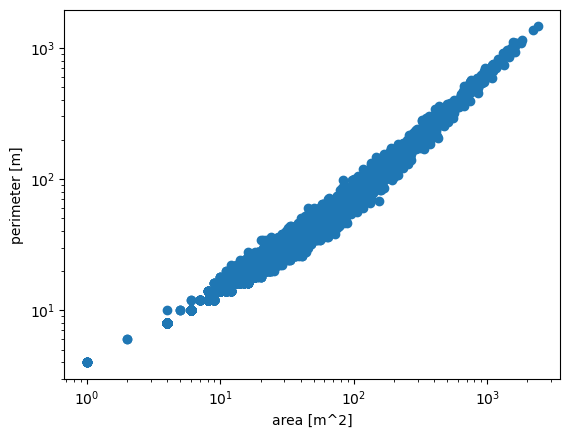

In [37]:
plt.figure(figsize=(11,8))
plt.rcParams.update({'font.size': 22})
plt.scatter(areas_ising, perimeters_ising)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

In [42]:
low_areas, low_perimeters = evaluation.get_lowest(areas_ising, perimeters_ising, bins = 50)

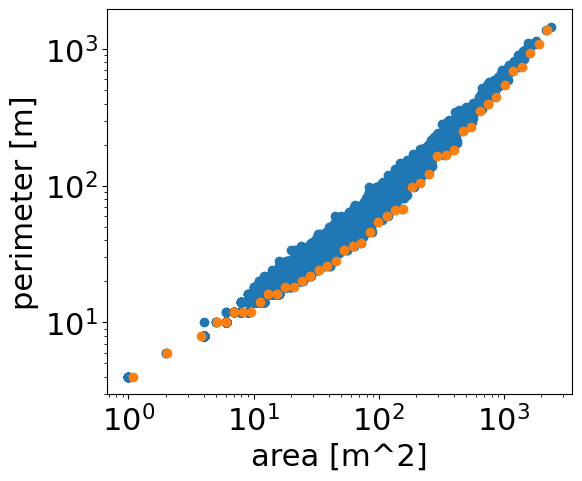

In [48]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 22})
plt.scatter(areas_ising, perimeters_ising)
plt.scatter(low_areas, low_perimeters)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

In [39]:
areas_dim, dimensions, _, areas_scatter, dimensions_scatter = evaluation.fractal_dim(ponds, -1, 1, 50)

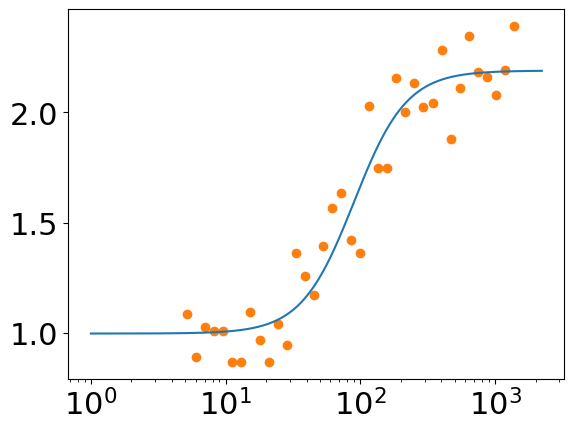

In [44]:
plt.plot(areas_dim, dimensions)
plt.scatter(areas_scatter, dimensions_scatter, color = 'C1')

plt.xscale('log')

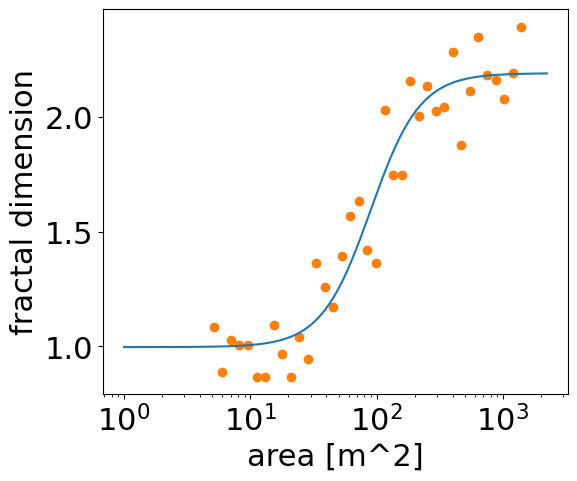

In [49]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 22})
plt.plot(areas_dim, dimensions)
plt.scatter(areas_scatter, dimensions_scatter, color = 'C1')
plt.xscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('fractal dimension')
plt.savefig("perimeter_area_scatter",bbox_inches="tight", dpi=300, transparent=True)

## For fun
Just a normal distribution with the heaviside function.

In [ ]:
size = 1000
h_norm = np.random.normal(loc = 0.5, scale = 1, size = (int(size/3), int(size/3)))
h_norm = resize(h_norm, (size, size))
h_norm = np.heaviside(h_norm-0.6, 0) * h_norm

In [ ]:
plt.figure()
plt.imshow(np.ma.masked_where(h_norm<=0, h_norm))
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(np.ma.masked_where(h_norm[:200, :200]<=0, h_norm[:200, :200]))
plt.colorbar()
plt.show()
plt.imshow(np.ma.masked_where(h_norm[:100, :100]<=0, h_norm[:100, :100]))
plt.colorbar()
plt.show()

In [ ]:
areas_norm, perimeters_norm = evaluation.perim_area(np.where(h_norm>0, -1, 1), pond_val = -1, ice_val = 1)

In [ ]:
plt.scatter(areas_norm, perimeters_norm, marker='x', label = 'normal distribution')
plt.scatter(areas_ca, perimeters_ca, facecolor='none', edgecolors='g', alpha=0.2, label = 'CA')
plt.scatter(areas_ising, perimeters_ising, marker='.', alpha=0.2, label = 'Ising')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area [m^2]')
plt.ylabel('perimeter [m]')